In [11]:
# This script corresponds to a simulation using different loss angles for the bulk/shear parts of the energy. This script checks the accuracy of the coating energy and coating thermal noise, then plot its convergence.

In [12]:
import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FuncFormatter, MaxNLocator

matplotlib.rcParams['text.usetex'] = True
plt.style.use('dark_background')

In [13]:
r_0_multiplier = 1.0
r_0 = 152.3108006676e-6 * r_0_multiplier
kB = 1.3806488e-23
# Temperature used and defined in the code
T = 305.
# Frequency
f = 100.
# Some papers use this def of r0.
wm = r_0 * np.sqrt(2)

F0 =  0.001
d = 4.68e-6
R = 12500.e-6

# Loss angles of the coating.
# Recall for a substrate with a single coating
# phi_FusedSilica = 1.e-6
# phi_Iso_Ta2O5 = 4.e-4
# phi_iso_AlGaAs = 2.5e-5
# phi_AlGaAs = 2.5 e-5

phiSub = 1.e-6
phiCoat = 2.5e-5

phiBulk = 7.75e-4
phiShear = 5.2e-7

# Possion ratio and Youngs modulus for a fused silica substrate.
ymSub = 72.E9
sigmaSub = 0.17

# Possion ratio and Youngs modulus for a isotropic AlGaAs coating.
ymCoat = 100.E9
sigmaCoat = 0.32

# Bulk and shear modulus for the coating, taken from Thorne + Blanford eq. 11.39
# We refer to mu as the shear modulus and K as the bulk modulus.

mu_coating = ymCoat/(2*(1 + sigmaCoat))
K_coating  = ymCoat/(3*(1 - 2*sigmaCoat))

# Bulk and shear modulus for the substrate, , taken from Thorne + Blanford eq. 11.39
mu_substrate = ymSub / (2*(1 + sigmaSub))
K_substrate  = ymSub / (3*(1 - 2*sigmaSub))


In [14]:
data = np.genfromtxt("Energy.dat")

coatingEnergy = data[:,3]
CoatEnergyNumerical = coatingEnergy[-1] * 1E-6 # To get to SI units

coatingNoise = data[:,5] 
CoatThermalNoiseNumerical = coatingNoise[-1] / np.sqrt(f)

bulkEnergy = data[:,10]
shearEnergy = data[:,11]

bulkEnergyNumerical = bulkEnergy[-1] * 1e-6
shearEnergyNumerical = shearEnergy[-1] * 1e-6

In [15]:
# This was the origonal formula used in the paper
# DOI: 	10.1088/1361-6382/aa9ccc
analytic_defunct = np.sqrt((2*kB*T/((math.pi**2)*f))*((1-(sigmaSub**2))/(wm*ymSub))*(d/wm)*((phiCoat)/(ymSub*ymCoat*(1-sigmaCoat**2)*(1-sigmaSub**2)))*(ymCoat**2*(1+sigmaSub)**2*(1-2*sigmaSub)**2+ymSub**2*(1+sigmaCoat)**2*(1-2*sigmaCoat)))

# These equations are ones I derived. They are the analytic solutions to the bulk/shear energies.
# We define the coating energy in terms of the bulk/shear energies which are defined in terms of 

# Equation 17
K_theta = (K_substrate + (mu_substrate / 3) + mu_coating) / ( (K_coating + ((4 / 3) * mu_coating))*(K_substrate + (mu_substrate/3)) )
# Equation 18
K_zz = (K_substrate + (mu_substrate / 3) + (mu_coating / 3) - (K_coating / 2) ) / ( (K_coating + ((4 / 3) * mu_coating))*(K_substrate + (mu_substrate/3)) )

# The energies, multiplied by their respective loss angle
bulk_energy_analytic = (d * K_coating * pow(K_theta, 2)) / (4 * math.pi * r_0**2)
shear_energy_analytic = ((2 * d * mu_coating  * (pow((K_theta - K_zz), 2) + pow(K_zz, 2))) - ((2 * d * mu_coating * pow(K_theta, 2))/3)) / (4 * math.pi * r_0**2)

# Coating Energy
analytic_coating_energy = (bulk_energy_analytic + shear_energy_analytic)

# Coating Thermal Noise
analytic_coating_thermal_noise = np.sqrt(((4 * kB * T) / (math.pi * f)) * (bulk_energy_analytic * phiBulk + shear_energy_analytic * phiShear))


# As a test, we can check to see how well the equation from Geoffrey's paper and the equations I have been using agree.

print(analytic_defunct)
print(analytic_coating_thermal_noise)



6.527843637825414e-19
3.1482333694915496e-18


In [16]:
# Lets measure the numerical results to the analytic results.

# Percent Difference, with a being the analytic solution
def PercentDifference(a, b):
    return(100 * np.abs(a-b)/a)

print("Analytic bulk energy is ", bulk_energy_analytic, ".")
print("Numerical bulk energy is ", bulkEnergyNumerical, ".")
print("Their percent difference is ", PercentDifference(bulk_energy_analytic, bulkEnergyNumerical), "%.\n")

print("Analytic shear energy is ", shear_energy_analytic, ".")
print("Numerical shear energy is ", shearEnergyNumerical, ".")
print("Their percent difference is ", PercentDifference(shear_energy_analytic, shearEnergyNumerical), "%.\n")
print("One reason that the shear energy might be so much higher is numerical accuracy. If you look at the equation for shear energy, we have a lot more terms.\n")

print("Analytic Coating Energy is ", analytic_coating_energy, ".")
print("Numerical Coating Energy is ", CoatEnergyNumerical, ".")
print("Their percent difference is ", PercentDifference(analytic_coating_energy, CoatEnergyNumerical), "%.\n")

print("Analytic Coating Thermal Noise is ", analytic_coating_thermal_noise, ".")
print("Numerical Coating Thermal Noise is ", CoatThermalNoiseNumerical, ".")
print("Their percent difference is ", PercentDifference(analytic_coating_thermal_noise, CoatThermalNoiseNumerical), "%.")



Analytic bulk energy is  2.3847447442940713e-10 .
Numerical bulk energy is  2.1746294054875998e-10 .
Their percent difference is  8.81081043617813 %.

Analytic shear energy is  7.943707075301387e-11 .
Numerical shear energy is  6.1747470183672e-11 .
Their percent difference is  22.268696971899256 %.

One reason that the shear energy might be so much higher is numerical accuracy. If you look at the equation for shear energy, we have a lot more terms.

Analytic Coating Energy is  3.17911545182421e-10 .
Numerical Coating Energy is  2.7921041073243e-10 .
Their percent difference is  12.173554259498147 %.

Analytic Coating Thermal Noise is  3.1482333694915496e-18 .
Numerical Coating Thermal Noise is  3.0062938926190004e-18 .
Their percent difference is  4.508543688280419 %.


In [17]:
# Now that we have seen that our results are close to the analytic solution, we can begin to plot the data. This plot shows how the total/coating energy converge with resolution.

bulkEnergy - data[:,10]
bulkEnergyDropLast = bulkEnergy[:-1]
bulkEnergyDropFirst = bulkEnergy[1:]
bulkEnergyDiff = np.abs(bulkEnergyDropLast - bulkEnergyDropFirst)
bulkEnergyDiffFrac = bulkEnergyDiff / bulkEnergyDropLast

shearEnergy = data[:,11]
shearEnergyDropLast = shearEnergy[:-1]
shearEnergyDropFirst = shearEnergy[1:]
shearEnergyDiff = np.abs(shearEnergyDropLast - shearEnergyDropFirst)
shearEnergyDiffFrac = shearEnergyDiff / shearEnergyDropLast

bulkEnergyOvershearEnergy = data[:,10]/data[:,11]
bulkEnergyOvershearEnergyDropLast = bulkEnergyOvershearEnergy[:-1]
bulkEnergyOvershearEnergyDropFirst = bulkEnergyOvershearEnergy[1:]
bulkEnergyOvershearEnergyDiff = np.abs(bulkEnergyOvershearEnergyDropLast - bulkEnergyOvershearEnergyDropFirst)
bulkEnergyOvershearEnergyDiffFrac = bulkEnergyOvershearEnergyDiff / bulkEnergyOvershearEnergyDropLast

totalEnergy = data[:,1]
totalEnergyDropLast = totalEnergy[:-1]
totalEnergyDropFirst = totalEnergy[1:]
totalEnergyDiff = np.abs(totalEnergyDropLast - totalEnergyDropFirst)
totalEnergyDiffFrac = totalEnergyDiff / totalEnergyDropLast

coatEnergy = data[:,3]
coatEnergyDropLast = coatEnergy[:-1]
coatEnergyDropFirst = coatEnergy[1:]
coatEnergyDiff = np.abs(coatEnergyDropLast - coatEnergyDropFirst)
coatEnergyDiffFrac = coatEnergyDiff / coatEnergyDropLast

coatingThermalNoise = data[:,5]
coatThermalNoiseDropLast  = coatingThermalNoise[:-1]
coatThermalNoiseDropFirst = coatingThermalNoise[1:]
coatThermalNoiseDiff = np.abs(coatThermalNoiseDropLast - coatThermalNoiseDropFirst)
coatThermalNoiseDiffFrac = coatThermalNoiseDiff / coatThermalNoiseDropLast

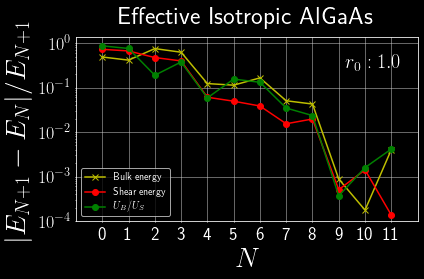

In [18]:
# Here we plot the bulk and shear energies

fig = plt.gcf()
ax = plt.gca()

gridwidth_1=0.5
gridcolor_1=(0.8,0.8,0.8)

myAxisLabelSize_1=28
myTickLabelSize_1=18
myTitleSize_1=25

ax.plot(data[:,0][:-1], bulkEnergyDiffFrac, marker='x', label='Bulk energy', color='y')
ax.plot(data[:,0][:-1], shearEnergyDiffFrac, marker='o', label='Shear energy', color='r')
ax.plot(data[:,0][:-1], bulkEnergyOvershearEnergyDiffFrac, marker='o', label=r'$U_B/U_S$', color='g')


ax.set_xlabel('$N$', fontsize=myAxisLabelSize_1)
ax.set_ylabel('$|E_{N+1} - E_{N}|/ E_{N+1}$ ', fontsize=myAxisLabelSize_1)

ax.set_yscale('log')

ax.set_xlim([-1,12])
ax.set_ylim([1e-4,0])


ax.tick_params(axis='x', labelsize=myTickLabelSize_1, pad=5, length=1)
ax.tick_params(which='minor', length=1)
ax.tick_params(axis='y', labelsize=myTickLabelSize_1, length=1)

N = 12
ind = np.arange(N)
plt.xticks(ind, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'))


ax.grid(b=True, which='major', color=gridcolor_1, linestyle='solid', linewidth=gridwidth_1)

ax.legend(loc='lower left', fontsize=10)
ax.set_title('Effective Isotropic AlGaAs', fontsize=myTitleSize_1, color='w', y=1.04)

txt_bulkshear_plot = r'$r_0 : {}$'.format(r_0_multiplier)
#ax.annotate(txt_bulkshear_plot, xy=(12, .5), xytext=(9, 0.0003), size=20)

ax.annotate(txt_bulkshear_plot, xy=(12, .5),
            xytext=(.95, 0.895), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top', size=20)



fig.tight_layout()

plt.savefig('BulkandShearEnergyConvergence.png')

pdf = PdfPages('BulkandShearEnergyConvergence.pdf')
pdf.savefig()
pdf.close()


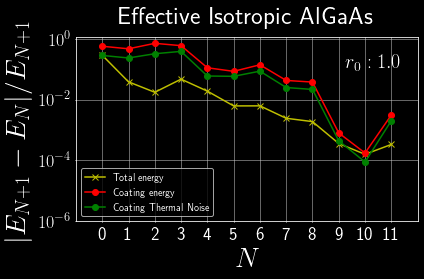

In [19]:


fig_1 = plt.gcf()
ax_1 = plt.gca()

ax_1.plot(data[:,0][:-1], totalEnergyDiffFrac, marker='x', label='Total energy', color='y')
ax_1.plot(data[:,0][:-1], coatEnergyDiffFrac, marker='o', label='Coating energy', color='r')
ax_1.plot(data[:,0][:-1], coatThermalNoiseDiffFrac, marker='o', label='Coating Thermal Noise', color='g')

ax_1.set_xlabel('$N$', fontsize=myAxisLabelSize_1)
ax_1.set_ylabel('$|E_{N+1} - E_{N}|/ E_{N+1}$ ', fontsize=myAxisLabelSize_1)

ax_1.set_yscale('log')

ax_1.set_xlim([-1,12])
ax_1.set_ylim([1e-6,0])


ax_1.tick_params(axis='x', labelsize=myTickLabelSize_1, pad=5, length=1)
ax_1.tick_params(which='minor', length=1)
ax_1.tick_params(axis='y', labelsize=myTickLabelSize_1, length=1)

N = 12
ind = np.arange(N)
plt.xticks(ind, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'))


ax_1.grid(b=True, which='major', color=gridcolor_1, linestyle='solid', linewidth=gridwidth_1)

ax_1.legend(loc='lower left', fontsize=10)
ax_1.set_title('Effective Isotropic AlGaAs', fontsize=myTitleSize_1, color='w', y=1.04)

txt_coating_energy_convergence = r'$r_0 : {}$'.format(r_0_multiplier)
#ax_1.annotate(txt_coating_energy_convergence, xy=(12, .5), xytext=(9, 0.00003), size=20)

ax_1.annotate(txt_coating_energy_convergence, xy=(12, .5),
            xytext=(.95, 0.895), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top', size=20)

fig_1.tight_layout()

plt.savefig('TotalAndCoatingEnergyConvergence.png')

pdf_1 = PdfPages('TotalAndCoatingEnergyConvergence.pdf')
pdf_1.savefig()
pdf_1.close()

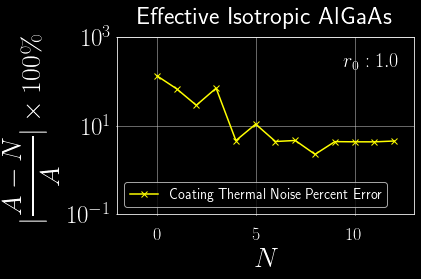

In [20]:
# What we can see now is that the coating energy is not converging.

# So how can we get such bad convergence, but have such well agreement with the thermal noise analytic solution? Well lets see how the coating thermal noise agrees with the solution as we increase the resolution.

# Okay from here on out, we are not doing a convergence test. 
# We are checking how well does the coating thermal noise numeric calculation agree with the analytic solution as we increase the resolution.


coatingThermalNoise = data[:,5] / np.sqrt(f)
coatThermalNoiseDiff_Analytic = np.abs(analytic_coating_thermal_noise - coatingThermalNoise)
coatThermalNoiseDiff_Analytic = 100 * (coatThermalNoiseDiff_Analytic/analytic_coating_thermal_noise)


fig_2 = plt.gcf()
ax_2 = plt.gca()

ax_2.plot(data[:,0], coatThermalNoiseDiff_Analytic, marker='x', label='Coating Thermal Noise Percent Error', color='yellow')

ax_2.set_xlim([-2,13])
ax_2.set_ylim([1e-1,1e3])

ax_2.set_yscale('log')

ax_2.set_xlabel('$N$', fontsize=myAxisLabelSize_1)
ax_2.set_ylabel(r'$|\displaystyle\frac{A-N}{A}| \times 100\%$', fontsize=myAxisLabelSize_1)

ax_2.tick_params(axis='x', labelsize=myTickLabelSize_1, pad=12, length=1)
ax_2.tick_params(which='minor', length=1)
ax_2.tick_params(axis='y', labelsize=25, length=1)

ax_2.grid(b=True, which='major', color=gridcolor_1, linestyle='solid', linewidth=gridwidth_1)

ax_2.legend(loc='lower left', fontsize=14)
ax_2.set_title('Effective Isotropic AlGaAs', fontsize=myTitleSize_1, color='w', y=1.04)

txt_percent_error = r'$r_0 : {}$'.format(r_0_multiplier)
ax_2.annotate(txt_percent_error, xy=(12, .5),
            xytext=(.95, 0.895), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top', size=20)

fig_2.tight_layout()

plt.savefig('CoatingThermalNoisePercentDifference.png')

pdf_2 = PdfPages('CoatingThermalNoisePercentDifference.pdf')
pdf_2.savefig()
pdf_2.close()

